# In conda env openAI
#sudo -H pip install python=3.5  
#sudo -H pip install tensorflow==1.3  
Also Kernel should be openAI  

In [1]:
%%bash
pwd

/Users/parksoy/Desktop/Soyoung_Udacity_ND_DeepLearning/6.Deep_Reinforcement_Learning/gym


# Deep $Q$-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use $Q$-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://github.com/openai/gym). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [2]:
import gym
import numpy as np

# Create the Cart-Pole game environment
env = gym.make('CartPole-v1')

# Number of possible actions
print('Number of possible actions:', env.action_space.n)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Number of possible actions: 2


/Users/parksoy/Desktop/Soyoung_Udacity_ND_DeepLearning/6.Deep_Reinforcement_Learning/gym/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`.  You can see how many actions are possible from `env.action_space.n`, and to get a random action you can use `env.action_space.sample()`.  Passing in an action as an integer to `env.step` will generate the next step in the simulation.  This is general to all Gym games. 

In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to interact with the environment.

In [3]:
actions = [] # actions that the agent selects
rewards = [] # obtained rewards
state = env.reset()

while True:
    action = env.action_space.sample()  # choose a random action
    state, reward, done, _ = env.step(action) 
    rewards.append(reward)
    actions.append(action)
    if done:
        break

We can look at the actions and rewards:

In [4]:
print('Actions:', actions)
print('Rewards:', rewards)

Actions: [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]
Rewards: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each step while the game is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## $Q$-Network

To keep track of the action values, we'll use a neural network that accepts a state $s$ as input.  The output will be $Q$-values for each available action $a$ (i.e., the output is **all** action values $Q(s,a)$ _corresponding to the input state $s$_).

<img src="assets/q-network.png" width=550px>

For this Cart-Pole game, the state has four values: the position and velocity of the cart, and the position and velocity of the pole.  Thus, the neural network has **four inputs**, one for each value in the state, and **two outputs**, one for each possible action. 

As explored in the lesson, to get the training target, we'll first use the context provided by the state $s$ to choose an action $a$, then simulate the game using that action. This will get us the next state, $s'$, and the reward $r$. With that, we can calculate $\hat{Q}(s,a) = r + \gamma \max_{a'}{Q(s', a')}$.  Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

Below is one implementation of the $Q$-network. It uses two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [5]:
import tensorflow as tf

class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

/Users/parksoy/anaconda3/envs/openAI/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/parksoy/anaconda3/envs/openAI/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maximum capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [6]:
from collections import deque

class Memory():
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## $Q$-Learning training algorithm

We will use the below algorithm to train the network.  For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode $\leftarrow 1$ **to** $M$ **do**
  * Observe $s_0$
  * **For** $t \leftarrow 0$ **to** $T-1$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s_t,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

You are welcome (and encouraged!) to take the time to extend this code to implement some of the improvements that we discussed in the lesson, to include fixed $Q$ targets, double DQNs, prioritized replay, and/or dueling networks.

## Hyperparameters

One of the more difficult aspects of reinforcement learning is the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [7]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [8]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

/Users/parksoy/anaconda3/envs/openAI/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/parksoy/anaconda3/envs/openAI/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Populate the experience memory

Here we re-initialize the simulation and pre-populate the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [9]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent.

In [10]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/cartpole.ckpt")

Episode: 1 Total reward: 7.0 Training loss: 1.1092 Explore P: 0.9993
Episode: 2 Total reward: 11.0 Training loss: 1.1641 Explore P: 0.9982
Episode: 3 Total reward: 15.0 Training loss: 1.1407 Explore P: 0.9967
Episode: 4 Total reward: 50.0 Training loss: 1.1097 Explore P: 0.9918
Episode: 5 Total reward: 10.0 Training loss: 1.0291 Explore P: 0.9908
Episode: 6 Total reward: 19.0 Training loss: 1.0594 Explore P: 0.9890
Episode: 7 Total reward: 50.0 Training loss: 1.2154 Explore P: 0.9841
Episode: 8 Total reward: 17.0 Training loss: 1.1852 Explore P: 0.9824
Episode: 9 Total reward: 20.0 Training loss: 1.2325 Explore P: 0.9805
Episode: 10 Total reward: 20.0 Training loss: 1.1708 Explore P: 0.9786
Episode: 11 Total reward: 18.0 Training loss: 1.2768 Explore P: 0.9768
Episode: 12 Total reward: 21.0 Training loss: 1.1892 Explore P: 0.9748
Episode: 13 Total reward: 19.0 Training loss: 1.2903 Explore P: 0.9730
Episode: 14 Total reward: 16.0 Training loss: 1.2104 Explore P: 0.9714
Episode: 15 Tota

Episode: 117 Total reward: 34.0 Training loss: 112.3697 Explore P: 0.7798
Episode: 118 Total reward: 20.0 Training loss: 2.6586 Explore P: 0.7782
Episode: 119 Total reward: 8.0 Training loss: 88.1147 Explore P: 0.7776
Episode: 120 Total reward: 10.0 Training loss: 2.1947 Explore P: 0.7769
Episode: 121 Total reward: 18.0 Training loss: 2.5402 Explore P: 0.7755
Episode: 122 Total reward: 8.0 Training loss: 67.7850 Explore P: 0.7749
Episode: 123 Total reward: 9.0 Training loss: 2.3048 Explore P: 0.7742
Episode: 124 Total reward: 22.0 Training loss: 2.2959 Explore P: 0.7725
Episode: 125 Total reward: 16.0 Training loss: 1.8436 Explore P: 0.7713
Episode: 126 Total reward: 17.0 Training loss: 58.4024 Explore P: 0.7700
Episode: 127 Total reward: 40.0 Training loss: 2.1555 Explore P: 0.7670
Episode: 128 Total reward: 13.0 Training loss: 54.7019 Explore P: 0.7660
Episode: 129 Total reward: 14.0 Training loss: 88.5387 Explore P: 0.7649
Episode: 130 Total reward: 18.0 Training loss: 1.8284 Explor

Episode: 231 Total reward: 63.0 Training loss: 17.8864 Explore P: 0.5900
Episode: 232 Total reward: 38.0 Training loss: 1.3710 Explore P: 0.5878
Episode: 233 Total reward: 28.0 Training loss: 1.6795 Explore P: 0.5862
Episode: 234 Total reward: 52.0 Training loss: 28.1404 Explore P: 0.5832
Episode: 235 Total reward: 102.0 Training loss: 1.1067 Explore P: 0.5774
Episode: 236 Total reward: 31.0 Training loss: 33.1753 Explore P: 0.5756
Episode: 237 Total reward: 34.0 Training loss: 1.4487 Explore P: 0.5737
Episode: 238 Total reward: 54.0 Training loss: 0.5579 Explore P: 0.5707
Episode: 239 Total reward: 33.0 Training loss: 1.2483 Explore P: 0.5688
Episode: 240 Total reward: 34.0 Training loss: 19.1471 Explore P: 0.5669
Episode: 241 Total reward: 68.0 Training loss: 1.2092 Explore P: 0.5631
Episode: 242 Total reward: 33.0 Training loss: 17.8639 Explore P: 0.5613
Episode: 243 Total reward: 87.0 Training loss: 24.6934 Explore P: 0.5565
Episode: 244 Total reward: 43.0 Training loss: 1.0881 Exp

Episode: 346 Total reward: 154.0 Training loss: 130.3820 Explore P: 0.3085
Episode: 347 Total reward: 127.0 Training loss: 1.9064 Explore P: 0.3047
Episode: 348 Total reward: 71.0 Training loss: 2.0096 Explore P: 0.3026
Episode: 349 Total reward: 94.0 Training loss: 2.2607 Explore P: 0.2999
Episode: 350 Total reward: 113.0 Training loss: 63.9981 Explore P: 0.2966
Episode: 351 Total reward: 57.0 Training loss: 2.2282 Explore P: 0.2950
Episode: 352 Total reward: 171.0 Training loss: 3.1583 Explore P: 0.2902
Episode: 353 Total reward: 82.0 Training loss: 61.3781 Explore P: 0.2879
Episode: 355 Total reward: 11.0 Training loss: 2.3020 Explore P: 0.2821
Episode: 356 Total reward: 105.0 Training loss: 1.0688 Explore P: 0.2792
Episode: 357 Total reward: 81.0 Training loss: 124.0490 Explore P: 0.2771
Episode: 358 Total reward: 72.0 Training loss: 28.0910 Explore P: 0.2752
Episode: 360 Total reward: 51.0 Training loss: 61.0379 Explore P: 0.2686
Episode: 361 Total reward: 110.0 Training loss: 1.5

Episode: 532 Total reward: 29.0 Training loss: 0.3889 Explore P: 0.0336
Episode: 534 Total reward: 9.0 Training loss: 0.5158 Explore P: 0.0331
Episode: 536 Total reward: 44.0 Training loss: 0.7383 Explore P: 0.0325
Episode: 538 Total reward: 26.0 Training loss: 148.4472 Explore P: 0.0320
Episode: 540 Total reward: 110.0 Training loss: 0.5192 Explore P: 0.0313
Episode: 542 Total reward: 47.0 Training loss: 0.6800 Explore P: 0.0308
Episode: 543 Total reward: 189.0 Training loss: 228.4059 Explore P: 0.0304
Episode: 544 Total reward: 198.0 Training loss: 235.6192 Explore P: 0.0300
Episode: 545 Total reward: 171.0 Training loss: 0.4741 Explore P: 0.0297
Episode: 546 Total reward: 188.0 Training loss: 0.3148 Explore P: 0.0293
Episode: 547 Total reward: 184.0 Training loss: 0.5103 Explore P: 0.0290
Episode: 548 Total reward: 198.0 Training loss: 0.9186 Explore P: 0.0286
Episode: 549 Total reward: 188.0 Training loss: 0.4456 Explore P: 0.0283
Episode: 550 Total reward: 188.0 Training loss: 368

Episode: 690 Total reward: 9.0 Training loss: 12.1380 Explore P: 0.0150
Episode: 691 Total reward: 10.0 Training loss: 1100.1948 Explore P: 0.0150
Episode: 692 Total reward: 10.0 Training loss: 9.7176 Explore P: 0.0150
Episode: 693 Total reward: 9.0 Training loss: 10.1468 Explore P: 0.0150
Episode: 694 Total reward: 9.0 Training loss: 8.7062 Explore P: 0.0150
Episode: 695 Total reward: 13.0 Training loss: 10.5805 Explore P: 0.0150
Episode: 696 Total reward: 12.0 Training loss: 6.2499 Explore P: 0.0150
Episode: 697 Total reward: 12.0 Training loss: 9.4076 Explore P: 0.0149
Episode: 698 Total reward: 10.0 Training loss: 10.4528 Explore P: 0.0149
Episode: 699 Total reward: 12.0 Training loss: 8.1091 Explore P: 0.0149
Episode: 700 Total reward: 13.0 Training loss: 1142.1177 Explore P: 0.0149
Episode: 701 Total reward: 9.0 Training loss: 14.8220 Explore P: 0.0149
Episode: 702 Total reward: 8.0 Training loss: 11.2562 Explore P: 0.0149
Episode: 703 Total reward: 12.0 Training loss: 1309.7698 

Episode: 827 Total reward: 86.0 Training loss: 184.2432 Explore P: 0.0123
Episode: 829 Total reward: 93.0 Training loss: 4.9372 Explore P: 0.0122
Episode: 831 Total reward: 22.0 Training loss: 6.7099 Explore P: 0.0121
Episode: 833 Total reward: 90.0 Training loss: 1.7394 Explore P: 0.0121
Episode: 835 Total reward: 80.0 Training loss: 1.8525 Explore P: 0.0120
Episode: 837 Total reward: 41.0 Training loss: 11.7343 Explore P: 0.0120
Episode: 839 Total reward: 41.0 Training loss: 1.2424 Explore P: 0.0119
Episode: 841 Total reward: 47.0 Training loss: 1.0741 Explore P: 0.0119
Episode: 843 Total reward: 56.0 Training loss: 7.1890 Explore P: 0.0118
Episode: 845 Total reward: 89.0 Training loss: 4.3489 Explore P: 0.0118
Episode: 847 Total reward: 66.0 Training loss: 2.4644 Explore P: 0.0117
Episode: 849 Total reward: 91.0 Training loss: 3.8193 Explore P: 0.0117
Episode: 851 Total reward: 54.0 Training loss: 2.1110 Explore P: 0.0116
Episode: 853 Total reward: 81.0 Training loss: 1.6638 Explore

## Visualizing training

Below we plot the total rewards for each episode. The rolling average is plotted in blue.

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

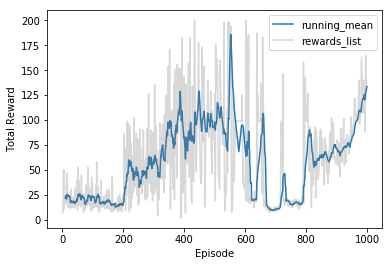

In [12]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews, label='running_mean')
plt.plot(eps, rews, color='grey', alpha=0.3, label='rewards_list')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()

![png](output_21_1.png)


## Playing Atari Games

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.